In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy.optimize import fsolve
import seaborn as sns
import wall_growth_kit as walkit

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Setting parameters
N=20 # Assume that the cell wall starts around 20 layers thick
r0=1.0 # initial radius in microns
l0=1 # initial cell length in microns
dt=1 # time between each step of layer removal and insertion, in minutes
dr=0.02/N # radial distance between each layer of PG in microns
PK_rat=0.1 # ratio of K to turgor pressure. Set to 1 initially for simplicity
alpha=0.225001 # ratio of longitudinal to circumferential stiffness
nu=0.45 # poisson ratio
numstep=500  # growth time in minutes to be simulated

# Initializing variables
ri=r0*np.ones(N) # rest initial radii
li=l0*np.exp(-np.log(2.0)*np.arange(0,N).astype(float)/N) # rest initial lengths - this assumes that the length 
# roughly doubles by the time the innermost layer moves through the full cell wall.
tvec=np.arange(numstep)
params={'dr':dr,'alpha':alpha,'nu':nu,'PK_rat':PK_rat}

# Now we do the actual simulation
radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt(tvec,ri,li,params)

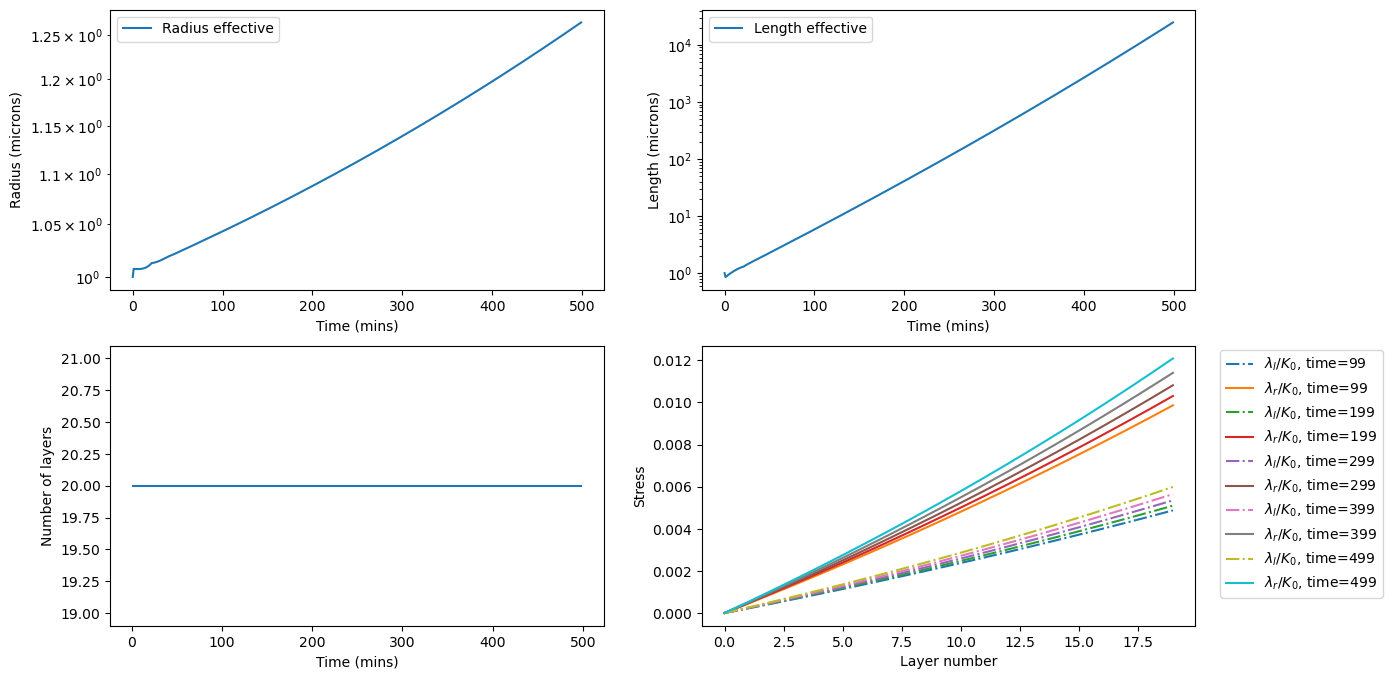

<Figure size 640x480 with 0 Axes>

In [5]:
rad_vals=np.asarray([temp[0] for temp in radii if len(temp)>0])
l_vals=np.asarray([temp[0] for temp in lengths if len(temp)>0])
num_layers=np.asarray([len(temp) for temp in lengths if len(temp)>0])
stiffnesses=np.ones(ri.shape)

fig=plt.figure(figsize=[14,8])
plt.subplot(2,2,1)
# plt.semilogy(tvec[1:len(rad_vals)-1],rad_vals[1:len(rad_vals)-1],label='Radius')
plt.semilogy(tvec,eff_rad,label='Radius effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Radius (microns)')
plt.subplot(2,2,2)
# plt.semilogy(tvec[1:len(rad_vals)-1],l_vals[1:len(l_vals)-1],label='Length')
plt.semilogy(tvec,eff_length,label='Length effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Length (microns)')
plt.subplot(2,2,3)
plt.plot(tvec[1:len(num_layers)-1],num_layers[1:len(num_layers)-1])
plt.xlabel('Time (mins)')
plt.ylabel('Number of layers')
plt.subplot(2,2,4)
for ind in np.arange(len(tvec)/5-1,len(tvec),len(tvec)/5):
    ind1=ind.astype(int)
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    # Now we calculate the tensions in each layer
    sig_l = dr*temp_si*((alpha/(alpha-nu**2))*eps_l+(nu/(alpha-nu**2))*eps_r) # the longitudinal tension in each layer 
    sig_r = dr*temp_si*((nu/(alpha-nu**2))*eps_l+(1/(alpha-nu**2))*eps_r) # the radial tension in each layer 
    plt.plot(sig_l,label=r'$\lambda_l/K_0$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
    plt.plot(sig_r,label=r'$\lambda_r/K_0$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Stress')
plt.legend(loc=[1.05,0.1])
plt.show()
# fig.savefig('./sample_trace_rico.png',dpi=300,bbox_inches='tight')
# fig.savefig('./sample_trace_rico.eps',bbox_inches='tight')
plt.clf()

Looks like our approach is working just fine, so let's produce a phase space similar to our previous approach.

In [19]:
r_inits=np.linspace(0.01,0.5,100)
alphas=np.linspace(0.025,1.0,40)

conv_mat1=np.empty([len(r_inits),len(alphas)])
grad_mat1=np.empty([len(r_inits),len(alphas)])
sign_mat1=np.empty([len(r_inits),len(alphas)])
for temp_ind0 in range(len(r_inits)):
    r0=r_inits[temp_ind0]
    ri=r0*np.ones(N) # rest initial radii
    for temp_ind1 in range(len(alphas)):
        alpha=alphas[temp_ind1]
        params['alpha']=alpha
        # Now we do the actual simulation
        radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt(tvec,ri,li,params)
        # Having simulated the growth, we will assess whether the radius converged or not
        xv=np.asarray([temp[0] for temp in radii])
        temp1=walkit.converges(xv[20:])
        conv_mat1[temp_ind0,temp_ind1]=temp1[0]
        grad_mat1[temp_ind0,temp_ind1]=temp1[1]
        sign_mat1[temp_ind0,temp_ind1]=temp1[2]

/Users/felixbarber/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/felixbarber/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


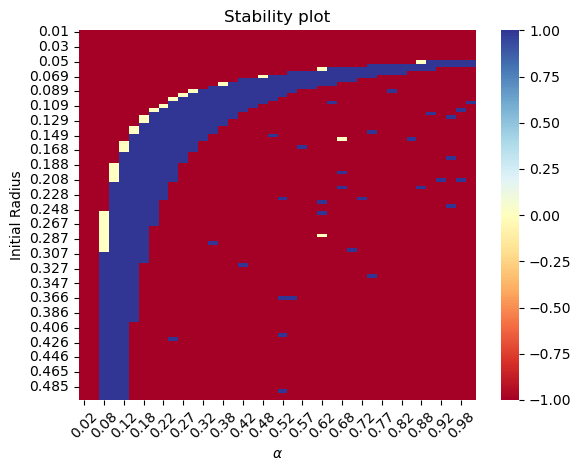

In [21]:
fig=plt.figure()
ax=plt.subplot(1,1,1)
sns.heatmap(sign_mat1,cmap='RdYlBu')
plt.title('Stability plot')
plt.xlabel(r'$\alpha$')
plt.ylabel('Initial Radius')
plt.xticks(ticks=ax.get_xticks(),labels=np.around(alphas[np.floor(ax.get_xticks()).astype(int)],2),rotation=45)
plt.yticks(ticks=ax.get_yticks(),labels=np.around(r_inits[np.floor(ax.get_yticks()).astype(int)],3),rotation=0.0)
fig.savefig('./230130_stability_plot_abrupt_hydrolysis.png',dpi=300,bbox_inches='tight')
plt.show()

Great, this looks just fine. Now, let's see the stability plot for seeding with $r0=1.0$, for a range of $\nu$ and $\alpha$ values.

In [139]:
r0=1.0
ri=r0*np.ones(N) # rest initial radii
nus=np.linspace(0.01,0.5,50)
alphas=np.linspace(0.01,0.5,50)

conv_mat1=np.empty([len(alphas),len(nus)])
grad_mat1=conv_mat1.copy()
sign_mat1=conv_mat1.copy()
for temp_ind0 in range(len(alphas)):
    alpha=alphas[temp_ind0]
    params['alpha']=alpha
    for temp_ind1 in range(len(nus)):
        nu=nus[temp_ind1]
        params['nu']=nu
        # Now we do the actual simulation
        radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt(tvec,ri,li,params)
        # Having simulated the growth, we will assess whether the radius converged or not
        xv=np.asarray([temp[0] for temp in radii])
        temp1=walkit.converges(xv[20:])
        conv_mat1[temp_ind0,temp_ind1]=temp1[0]
        grad_mat1[temp_ind0,temp_ind1]=temp1[1]
        sign_mat1[temp_ind0,temp_ind1]=temp1[2]

/Users/felixbarber/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

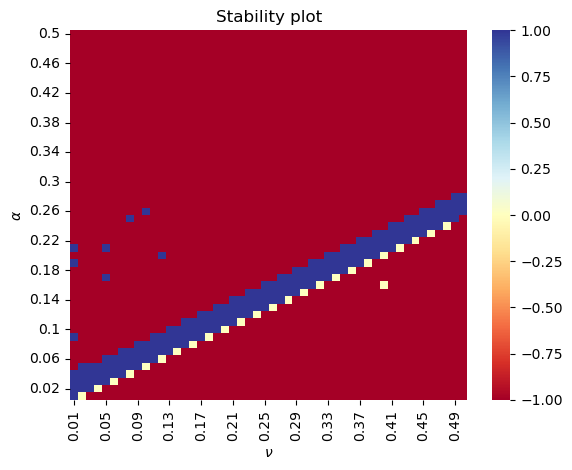

In [45]:
temp_alphas=alphas[::-1]
fig=plt.figure()
tickskip=2
ax=plt.subplot(1,1,1)
sns.heatmap(sign_mat1[::-1,:],cmap='RdYlBu')
plt.title('Stability plot')
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$\nu$')
plt.xticks(ticks=ax.get_xticks()[::tickskip],labels=np.around(nus[np.floor(ax.get_xticks()[::tickskip]).astype(int)],2),rotation=90.0)
plt.yticks(ticks=ax.get_yticks()[::tickskip],labels=np.around(temp_alphas[np.floor(ax.get_yticks()[::tickskip]).astype(int)],3),rotation=0.0)
fig.savefig('./230130_stability_plot_abrupt_hydrolysis_alpha_nu.png',dpi=300,bbox_inches='tight')
plt.show()

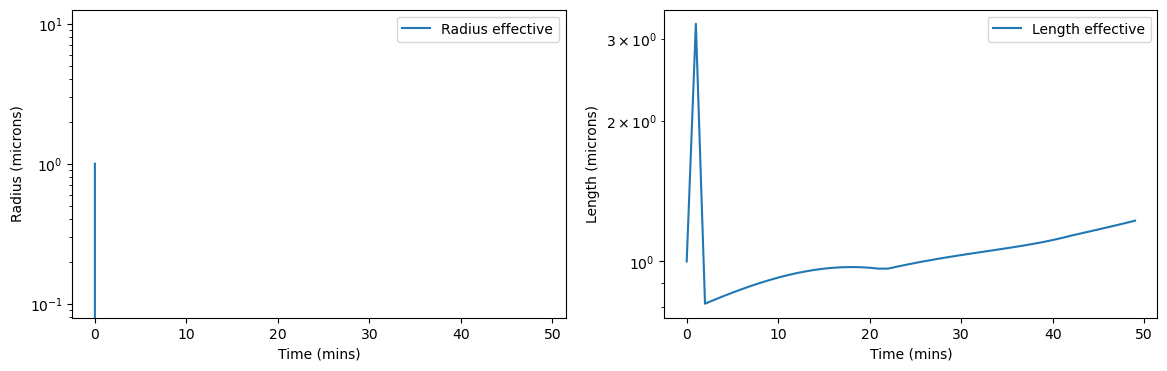

Stability = -1
Note: 1 implies radius increases, -1 implies radius decreases. 0 implies stable.


<Figure size 640x480 with 0 Axes>

In [137]:
# Setting parameters
N=20 # Assume that the cell wall starts around 20 layers thick
r0=1.0 # initial radius in microns
l0=1 # initial cell length in microns
dt=1 # time between each step of layer removal and insertion, in minutes
dr=0.02/N # radial distance between each layer of PG in microns
PK_rat=0.1 # ratio of K to turgor pressure. Set to 1 initially for simplicity
alpha=0.3 # ratio of longitudinal to circumferential stiffness
nu=0.1 # poisson ratio
numstep=50  # growth time in minutes to be simulated

# Initializing variables
ri=r0*np.ones(N) # rest initial radii
li=l0*np.exp(-np.log(2.0)*np.arange(0,N).astype(float)/N) # rest initial lengths - this assumes that the length 
# roughly doubles by the time the innermost layer moves through the full cell wall.
tvec=np.arange(numstep)
params={'dr':dr,'alpha':alpha,'nu':nu,'PK_rat':PK_rat}

# Now we do the actual simulation
radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt(tvec,ri,li,params)

rad_vals=np.asarray([temp[0] for temp in radii if len(temp)>0])
l_vals=np.asarray([temp[0] for temp in lengths if len(temp)>0])
num_layers=np.asarray([len(temp) for temp in lengths if len(temp)>0])
stiffnesses=np.ones(ri.shape)


# Brief plotting
fig=plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.semilogy(tvec,eff_rad,label='Radius effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Radius (microns)')
plt.subplot(1,2,2)
plt.semilogy(tvec,eff_length,label='Length effective')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Length (microns)')
plt.show()
plt.clf()

# Testing stability
# temp=scipy.stats.linregress(tvec[:10],eff_rad[:10])[0]
# cutoff=0.5
# out=0
# if temp>r0/tvec[-1]:
#     out=1
# elif -temp>r0/tvec[-1]:
#     out=-1

out=walkit.convergence_v1(eff_rad)

print('Stability = {0}'.format(out)) 
print('Note: 1 implies radius increases, -1 implies radius decreases. 0 implies stable.')

In [146]:
r0=1.0
ri=r0*np.ones(N) # rest initial radii
nus=np.linspace(0.005,0.5,100)
alphas=np.linspace(0.005,0.5,100)

conv_mat1=np.empty([len(alphas),len(nus)])
for temp_ind0 in range(len(alphas)):
    alpha=alphas[temp_ind0]
    params['alpha']=alpha
    for temp_ind1 in range(len(nus)):
        nu=nus[temp_ind1]
        params['nu']=nu
        # Now we do the actual simulation
        radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt(tvec,ri,li,params)
        # Having simulated the growth, we will assess whether the radius converged or not
        xv=np.asarray([temp[0] for temp in radii])
        temp1=walkit.convergence_v1(xv)
        conv_mat1[temp_ind0,temp_ind1]=temp1

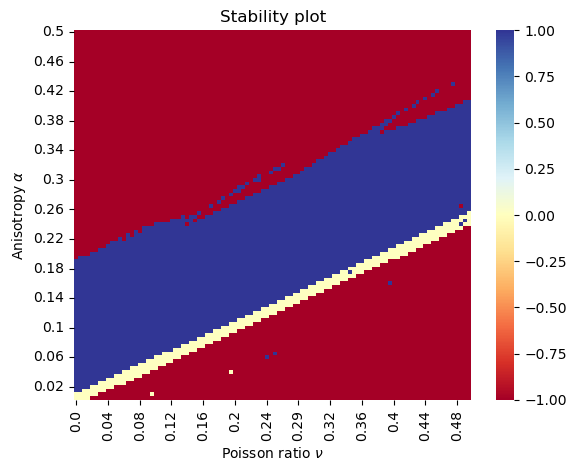

In [154]:
temp_alphas=alphas[::-1]
fig=plt.figure()
tickskip=2
ax=plt.subplot(1,1,1)
sns.heatmap(conv_mat1[::-1,:],cmap='RdYlBu')
plt.title('Stability plot')
plt.ylabel(r'Anisotropy $\alpha$')
plt.xlabel(r'Poisson ratio $\nu$')
plt.xticks(ticks=ax.get_xticks()[::tickskip],labels=np.around(nus[np.floor(ax.get_xticks()[::tickskip]).astype(int)],2),rotation=90.0)
plt.yticks(ticks=ax.get_yticks()[::tickskip],labels=np.around(temp_alphas[np.floor(ax.get_yticks()[::tickskip]).astype(int)],3),rotation=0.0)
fig.savefig('./230130_stability_plot_abrupt_hydrolysis_alpha_nu.png',dpi=300,bbox_inches='tight')
fig.savefig('./230130_stability_plot_abrupt_hydrolysis_alpha_nu.eps',bbox_inches='tight')
plt.show()

In [160]:
def constraint_plot(temp_nu,temp_xi):
    return (1+(temp_xi-2)*temp_nu)/(2*temp_xi)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


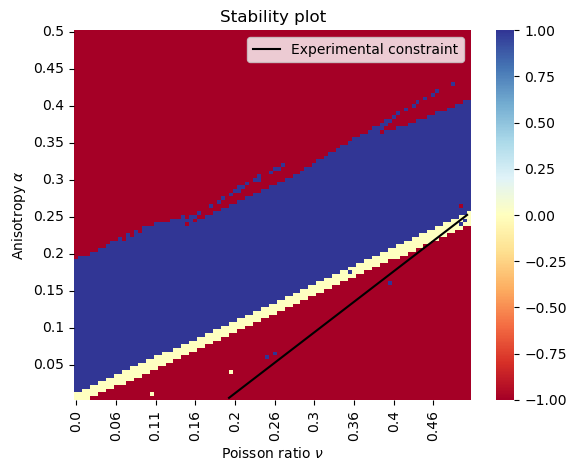

In [199]:
temp_alphas=alphas[::-1]
fig=plt.figure()
tickskip=10
ax=plt.subplot(1,1,1)
# sns.lineplot(x=xv,y=yv,label='Constraint',color='k')
sns.heatmap(conv_mat1[::-1,:],cmap='RdYlBu',xticklabels=nus,yticklabels=alphas[::-1])

# xv=np.linspace(0.0,np.amax(nus),100)
rat=(-4.8669*10**(-5))/(1.5809*10**(-5))
yv=constraint_plot(nus,rat)
ind=np.nonzero(yv>0)[0][0]
# plt.plot(xv,yv,label='Constraint')
temp_xv=np.arange(ind,len(nus))
temp_yv=len(alphas)-yv[ind:]*len(alphas)/np.amax(alphas)
plt.plot(temp_xv,temp_yv,label='Experimental constraint',color='k')
plt.legend()
plt.title('Stability plot')
plt.ylabel(r'Anisotropy $\alpha$')
plt.xlabel(r'Poisson ratio $\nu$')
plt.xticks(ticks=ax.get_xticks()[::tickskip],labels=np.around(nus[np.floor(ax.get_xticks()[::tickskip]).astype(int)],2),rotation=90.0)
plt.yticks(ticks=ax.get_yticks()[::tickskip],labels=np.around(temp_alphas[np.floor(ax.get_yticks()[::tickskip]).astype(int)],3),rotation=0.0)
fig.savefig('./230130_stability_plot_abrupt_hydrolysis_alpha_nu_overlay.png',dpi=300,bbox_inches='tight')
fig.savefig('./230130_stability_plot_abrupt_hydrolysis_alpha_nu_overlay.eps',bbox_inches='tight')
